# Investment Assignment 
## Saiyana Ramisetty

Spark Funds (an asset management company) wants to make investments in a few companies. The goal of this assignment is to understand the global trends in investments to take effective decisions.

**Business objective**: The objective is to identify the best sectors, countries, and a suitable investment type for making investments. The overall strategy is to invest where others are investing, implying that the 'best' sectors and countries are the ones 'where most investors are investing'.

**Constraints:**
Spark Funds has two minor constraints for investments:
 - It wants to invest between 5 to 15 million USD per round of investment
 - It wants to invest only in English-speaking countries because of the ease of communication with the companies it would invest in

**Understanding the data**: Overall dataset consists of 3 files, (companies.txt, rounds2.csv, mappings.csv)

 - **companies.txt**: A table with basic data of companies - Company details
 - **rounds2.csv**: Funding round details
 - **mappings.csv**: This file maps the numerous category names in the companies table (such 3D printing, aerospace, agriculture, etc.) to eight broad sector names. The purpose is to simplify the analysis into eight sector buckets, rather than trying to analyse hundreds of them. - Section Classification

## Checkpoint 1 - Data Cleaning
This step includes the following operations:
 - Data Loading
 - Understanding the data
 - Checking for Data inconsistency

In [1]:
# Import statements

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
# Data Loading

path_var = "" # Replace correct path

companies = pd.read_csv(path_var + "companies.txt", encoding = "ISO-8859-1", sep = "\t")
companies["permalink"] = companies["permalink"].str.encode("ISO-8859-1").str.decode("ascii", "ignore")
companies["name"] = companies["name"].str.encode("ISO-8859-1").str.decode("ascii", "ignore")

rounds2 = pd.read_csv(path_var + "rounds2.csv", encoding = "ISO-8859-1")
rounds2["company_permalink"] = rounds2["company_permalink"].str.encode("ISO-8859-1").str.decode("ascii", "ignore")

In [3]:
# Understanding the data

# companies dataframe has important information such as the unique_id of the company, catergory_list, country_code

companies.describe()
# companies.head(5)

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
count,66368,66367,61310,63220,66368,59410,57821,58338,58340,51147
unique,66368,66102,61191,27296,4,137,311,1092,5111,3978
top,/Organization/Feedvisor,Spire,http://www.askforoffer.com,Software,operating,USA,CA,SF Bay Area,San Francisco,01-01-2012
freq,1,4,5,3995,53034,37601,12900,8804,3526,2730


In [4]:
# rounds2 dataframe has important information such as the funding_round_type, raised_amount_usd, unique_id of the company

rounds2.info()
# companies.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114949 entries, 0 to 114948
Data columns (total 6 columns):
company_permalink          114949 non-null object
funding_round_permalink    114949 non-null object
funding_round_type         114949 non-null object
funding_round_code         31140 non-null object
funded_at                  114949 non-null object
raised_amount_usd          94959 non-null float64
dtypes: float64(1), object(5)
memory usage: 5.3+ MB


In [5]:
# Checking for Data inconsistency

# Converting the unique_ids of the companies to lower case to avoid miscalculations during further analysis

rounds2["company_permalink"] = rounds2["company_permalink"].str.lower()
companies["permalink"] = companies["permalink"].str.lower()

## Understanding the dataset

 - How many **unique companies** are present in **rounds2**? - 66368

In [6]:
unique_in_rounds_count = rounds2["company_permalink"].nunique(dropna = True)
unique_in_rounds_count

66368

 - How many **unique companies** are present in **companies**? - 66368

In [7]:
unique_in_companies_count = companies["permalink"].nunique(dropna = True)
unique_in_companies_count

66368

 - In the **companies** data frame, which column can be used as the unique key for each company? Write the **name of the column**. - permalink

 - Are there any companies in the rounds2 file which are not present in companies? - No

In [8]:
# Find out unique companies from both the dataframes

unique_in_rounds = pd.DataFrame({"company_id" : rounds2["company_permalink"].unique()})
unique_in_companies = pd.DataFrame({"company_id" : companies["permalink"].unique()})

# Companies which are only present in rounds2 but not in companies (rounds2 - companies)

all_companies_merged = unique_in_rounds.merge(unique_in_companies, on = ["company_id"])
only_in_rounds_not_in_companies = unique_in_rounds[ ~ unique_in_rounds["company_id"].isin(all_companies_merged["company_id"])]

len(only_in_rounds_not_in_companies)

0

 - Merge the two data frames so that all  variables (columns)  in the **companies** frame are added to the **rounds2** data frame. Name the merged frame **master_frame**. How many observations are present in master_frame ? - 114949

In [9]:
master_frame = pd.merge(left = rounds2, right = companies, left_on = "company_permalink", right_on = "permalink", how = "left")
len(master_frame)

114949

## Checkpoint 2: Funding Type Analysis
The funding types such as seed, venture, angel, etc. depend on the type of the company (startup, corporate, etc.), its stage (early stage startup, funded startup, etc.), the amount of funding (a few million USD to a billion USD), and so on.

Spark Funds wants to choose one of these four investment types for each potential investment they will make.

Handling missing values :
Next step is to check for null values and handling them based on the features importance in the analysis.
Percentage of NaN values present in the master_frame:

In [10]:
master_frame["funding_round_type"] = master_frame["funding_round_type"].str.lower()
round(100 * (master_frame.isnull().sum() / len(master_frame)), 2)

company_permalink           0.00
funding_round_permalink     0.00
funding_round_type          0.00
funding_round_code         72.91
funded_at                   0.00
raised_amount_usd          17.39
permalink                   0.00
name                        0.00
homepage_url                5.34
category_list               2.97
status                      0.00
country_code                7.55
state_code                  9.52
region                      8.84
city                        8.84
founded_at                 17.85
dtype: float64

We can here clearly see that "raised_amount_usd", "category_list", "country_code" columns have missing values.

Handling missing values for "raised_amount_usd":
One of the important factor "raised_amount_usd" is dependent on is the type of investment (seed, angel, venture, ...)

Categorizing the total data into seperate investment types for better analysis. And the four funding types that Spark firm is interested in are the seed, angel, venture and private_equity.

In [11]:
seed_FT = master_frame[master_frame["funding_round_type"] == "seed"]
angel_FT = master_frame[master_frame["funding_round_type"] == "angel"]
venture_FT = master_frame[master_frame["funding_round_type"] == "venture"]
private_FT = master_frame[master_frame["funding_round_type"] == "private_equity"]

In [12]:
# Calculating the skewness

seed_skew = seed_FT.skew(axis = 0, skipna = True)
angel_skew = angel_FT.skew(axis = 0, skipna = True)
venture_skew = venture_FT.skew(axis = 0, skipna = True)
private_equity_skew = private_FT.skew(axis = 0, skipna = True)

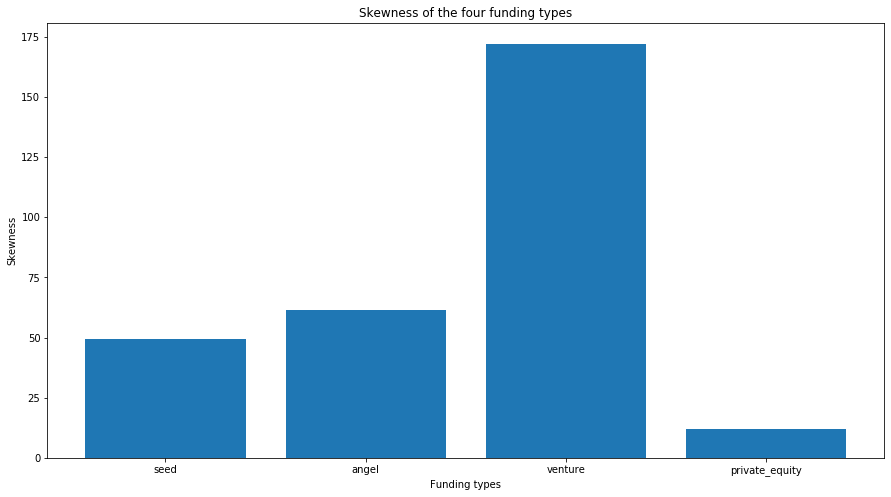

In [13]:
# Plotting skewness among the four FTs

plt.figure(figsize = (15,8))
bars = ("seed", "angel", "venture", "private_equity")
y_pos = np.arange(len(bars))
plt.bar(y_pos, [seed_skew[0], angel_skew[0], venture_skew[0], private_equity_skew[0]])
plt.xticks(y_pos, bars)
plt.title("Skewness of the four funding types")
plt.xlabel("Funding types")
plt.ylabel("Skewness")
plt.show()

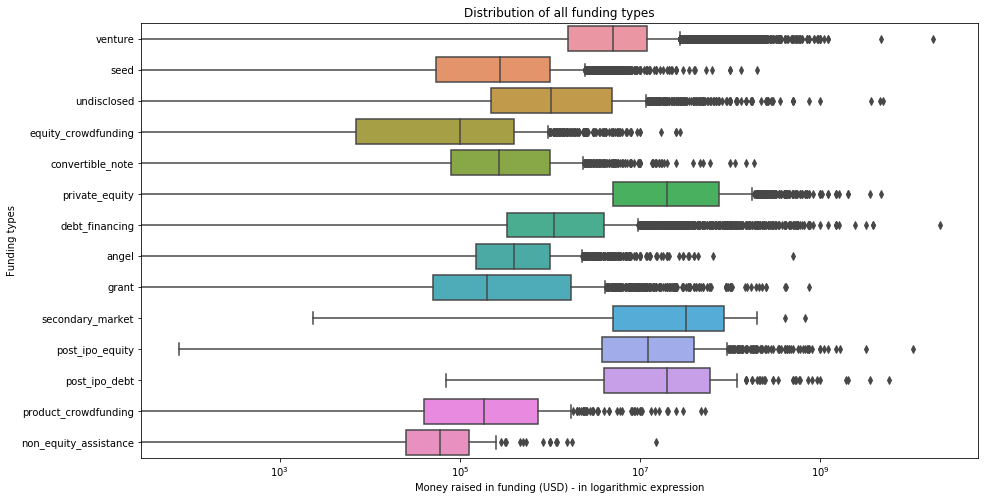

In [14]:
# Distribution of all FTs

plt.figure(figsize = (15,8))
sns.boxplot(master_frame["raised_amount_usd"], master_frame["funding_round_type"])
plt.xscale("log")
plt.title("Distribution of all funding types")
plt.xlabel("Money raised in funding (USD) - in logarithmic expression")
plt.ylabel("Funding types")
plt.show()

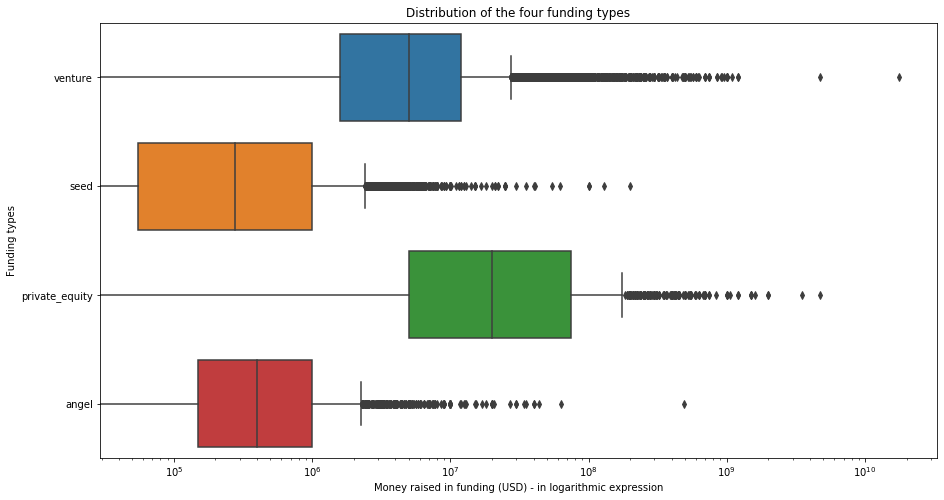

In [15]:
# Distribution of the 4 FTs

plt.figure(figsize = (15,8))
plotting_frame = master_frame[master_frame["funding_round_type"].isin(["seed", "angel", "venture", "private_equity"])]
sns.boxplot(plotting_frame["raised_amount_usd"], plotting_frame["funding_round_type"])
plt.xscale("log")
plt.title("Distribution of the four funding types")
plt.xlabel("Money raised in funding (USD) - in logarithmic expression")
plt.ylabel("Funding types")
plt.show()

As we can see there are a lot of outliers for each distribution and "raised_amount_usd" is an important feature to be considered, but with 17.39% of missing values. Hence dropping off the rows with missing values of "raised_amount_usd".

In [16]:
master_frame = master_frame[ ~ master_frame["raised_amount_usd"].isnull()]

"category_list" and "country_code" have a less percentage of missing values when compared to others, and no dependent feature. As they are categorical features, replacing the NaN values with their mode. And dropping off the rows with missing values of "category_list" and "country_code".

In [17]:
master_frame["category_list"].fillna(master_frame["category_list"].mode(dropna = True), inplace = True)
master_frame = master_frame[ ~ master_frame["category_list"].isnull()]

master_frame["country_code"].fillna(master_frame["country_code"].mode(dropna = True), inplace = True)
master_frame = master_frame[ ~ master_frame["country_code"].isnull()]

In [18]:
# Maintaining an original copy of master_frame

original_master_frame = master_frame.copy()
original_master_frame["raised_amount_usd"] = original_master_frame["raised_amount_usd"] / 1000000
original_master_frame.head(5)

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10.00000,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,0.70000,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2.00000,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007
6,/organization/01games-technology,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,undisclosed,NaN,01-07-2014,0.04125,/organization/01games-technology,01Games Technology,http://www.01games.hk/,Games,operating,HKG,NaN,Hong Kong,Hong Kong,NaN
7,/organization/0ndine-biomedical-inc,/funding-round/2b9d3ac293d5cdccbecff5c8cb0f327d,seed,NaN,11-09-2009,0.04336,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,http://ondinebio.com,Biotechnology,operating,CAN,BC,Vancouver,Vancouver,01-01-1997


Dropping redundanct/uneccessary columns from the master_frame.

For our analysis we require:
 - company_permalink
 - funding_round_type
 - raised_amount_usd
 - name
 - category_list
 - country_code

In [19]:
# Dataset Cleaning

master_frame = master_frame.drop(["funding_round_permalink", "funding_round_code", "funded_at", "permalink", "homepage_url", "status", "state_code", "region", "city", "founded_at"], axis = 1)
master_frame.head(5)

,company_permalink,funding_round_type,raised_amount_usd,name,category_list,country_code
0,/organization/-fame,venture,10000000.0,#fame,Media,IND
2,/organization/-qounter,seed,700000.0,:Qounter,Application Platforms|Real Time|Social Network...,USA
4,/organization/0-6-com,venture,2000000.0,0-6.com,Curated Web,CHN
6,/organization/01games-technology,undisclosed,41250.0,01Games Technology,Games,HKG
7,/organization/0ndine-biomedical-inc,seed,43360.0,Ondine Biomedical Inc.,Biotechnology,CAN


In [20]:
round(100 * (master_frame.isnull().sum() / len(master_frame)), 2)

company_permalink     0.0
funding_round_type    0.0
raised_amount_usd     0.0
name                  0.0
category_list         0.0
country_code          0.0
dtype: float64

Now all the features have 0 missing values.

Considering the constraints Spark Funds wants to choose one of these four investment types for each potential investment they will make.

 - Calculate the most representative value of the investment amount for each of the four funding types (venture, angel, seed, and private equity)
 - Based on the most representative investment amount calculated above, which investment type do you think is the most suitable for Spark Funds?

In [21]:
# Filtering the master_frame with only 4 funding types and fractioning the "raised_amount_usd" for better graphical representation

master_frame = master_frame[master_frame["funding_round_type"].isin(["seed", "angel", "venture", "private_equity"])]
master_frame["raised_amount_usd"] = master_frame["raised_amount_usd"] / 1000000

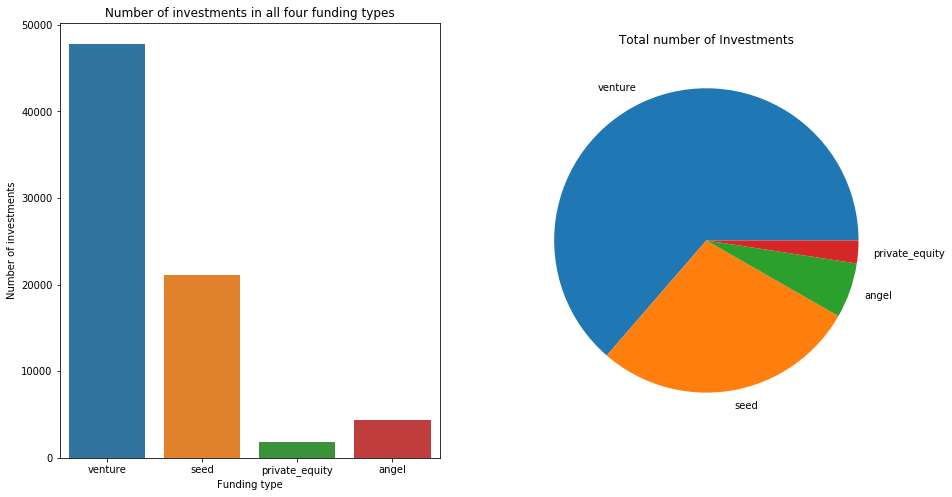

In [22]:
# Comparing the 4 funding type investments

plt.figure(figsize = (15,8))
plt.subplot(1, 2, 1)
sns.countplot(master_frame["funding_round_type"])
plt.title("Number of investments in all four funding types")
plt.xlabel("Funding type")
plt.ylabel("Number of investments")

plt.subplot(1, 2, 2)
investment_types_count = master_frame["funding_round_type"].value_counts()
plt.pie(investment_types_count.values, labels = investment_types_count.index)
plt.title("Total number of Investments")
plt.show()

It is clearly visible that the "venture" funding type is the most common funding type among the four investment types. Spark Funds wants to invest where most other investors are investing. This pattern is often observed among early stage startup investors

Choosing the most representative value of the investment amount - As this is numerical feature, let us consider the averages such as mean and median.

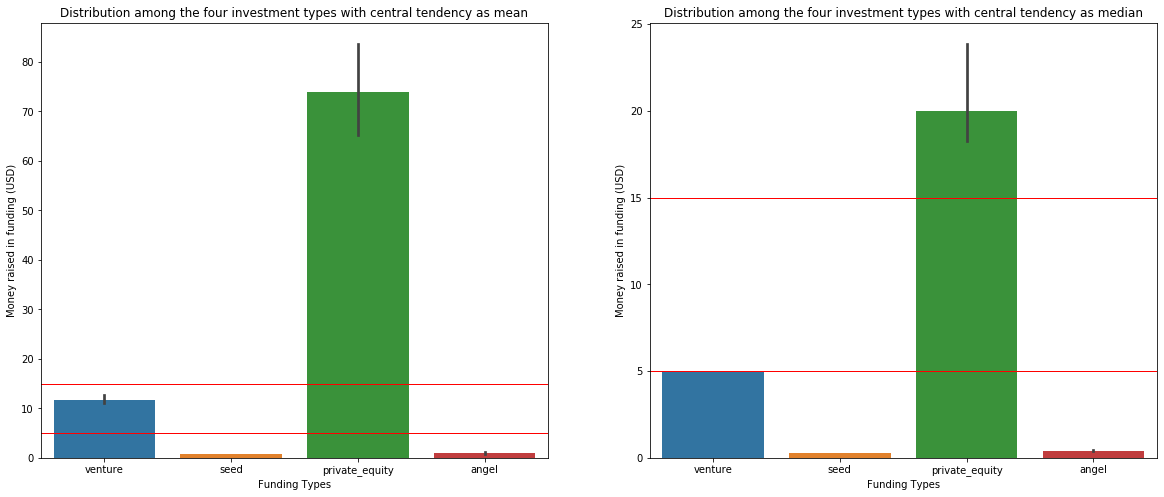

In [23]:
# Plotting averages

plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
sns.barplot(master_frame["funding_round_type"], master_frame["raised_amount_usd"], estimator = np.mean)
plt.axhline(y = 5, color = "red", linewidth = 1)
plt.axhline(y = 15, color = "red", linewidth = 1)
plt.title("Distribution among the four investment types with central tendency as mean")
plt.xlabel("Funding Types")
plt.ylabel("Money raised in funding (USD)")

plt.subplot(1, 2, 2)
sns.barplot(master_frame["funding_round_type"], master_frame["raised_amount_usd"], estimator = np.median)
plt.axhline(y = 5, color = "red", linewidth = 1)
plt.axhline(y = 15, color = "red", linewidth = 1)
plt.title("Distribution among the four investment types with central tendency as median")
plt.xlabel("Funding Types")
plt.ylabel("Money raised in funding (USD)")
plt.show()

### Clearly, from the above plots we can conclude that "venture" funding type is the most common investment type and the most representative value of investment amount is the "mean". With the combination of these both, we can see that the range falls between 5 to 15 million USD amounts.

In [24]:
# Storing the data for plots (checkpoint 6)

plots_frame = master_frame.copy()

##  Average Values of Investments for Each of these Funding Types

 - Average funding amount of **venture** type - 11.72 million USD 

In [25]:
round(master_frame[master_frame["funding_round_type"] == "venture"]["raised_amount_usd"].mean(), 2)

11.72

 - Average funding amount of **angel** type - 0.97 million USD

In [26]:
round(master_frame[master_frame["funding_round_type"] == "angel"]["raised_amount_usd"].mean(), 2)

0.97

 - Average funding amount of **seed** type - 0.75 million USD

In [27]:
round(master_frame[master_frame["funding_round_type"] == "seed"]["raised_amount_usd"].mean(), 2)

0.75

 - Average funding amount of **private equity** type - 73.94 million USD

In [28]:
round(master_frame[master_frame["funding_round_type"] == "private_equity"]["raised_amount_usd"].mean(), 2)

73.94

 - Considering that Spark Funds wants to invest between **5 to 15 million USD** per  investment round, which investment type is the most suitable for them? - venture

In [29]:
# Filtering out only "venture" type funds

master_frame = master_frame[master_frame["funding_round_type"].isin(["venture"])]

## Checkpoint 3 - Country Analysis
Spark Funds wants to invest in countries with the highest amount of funding for the chosen investment type. This is a part of its broader strategy to invest where **most investments are occurring.**

In [30]:
# Getting top 9 countries with highest number of investments and highest investment amounts.

top9_counts = master_frame.groupby("country_code")["raised_amount_usd"].count().sort_values(ascending = False).head(9).to_frame()

top9_amounts = master_frame.groupby("country_code")["raised_amount_usd"].sum().sort_values(ascending = False).head(9).to_frame()
top9_countries = top9_amounts.index.values

top9 = master_frame[master_frame["country_code"].isin(top9_countries)]

In [31]:
# Top 9 countries which have received the highest total funding

top9.groupby("country_code")["raised_amount_usd"].sum().sort_values(ascending = False)

country_code
USA    420068.029342
CHN     39338.918773
GBR     20072.813004
IND     14261.508718
CAN      9482.217668
FRA      7226.851352
ISR      6854.350477
DEU      6306.921981
JPN      3167.647127
Name: raised_amount_usd, dtype: float64

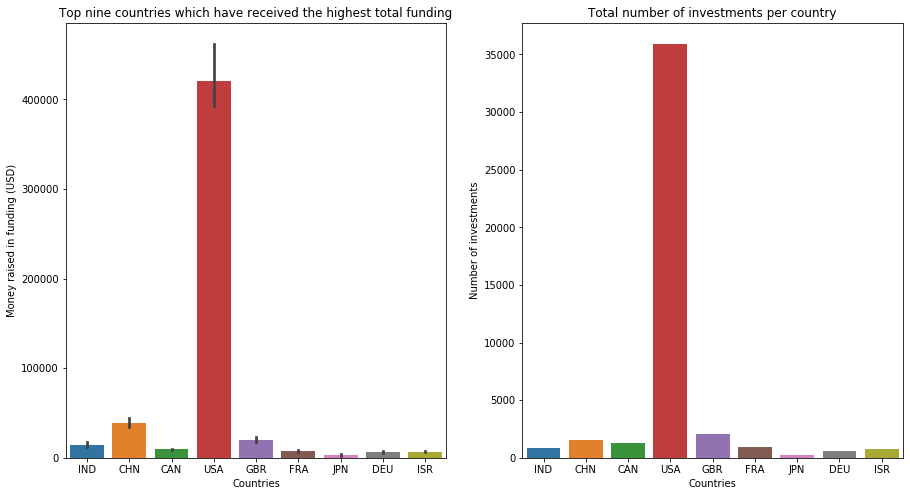

In [32]:
# Plotting the top 9 countries amounts and number of investments

plt.figure(figsize = (15,8))
plt.subplot(1, 2, 1)
sns.barplot(top9["country_code"], top9["raised_amount_usd"], estimator = sum)
plt.title("Top nine countries which have received the highest total funding")
plt.xlabel("Countries")
plt.ylabel("Money raised in funding (USD)")

plt.subplot(1, 2, 2)
sns.countplot(top9["country_code"])
plt.title("Total number of investments per country")
plt.xlabel("Countries")
plt.ylabel("Number of investments")
plt.show()

### From the plot above we can conclude that USA, BGR, IND are the three top english speaking countries (which have english as their official language - picking manually) because Spark Fund wants to only invest in english speaking countries.

USA being the top most invested country.

## Analysing the Top 3 English-Speaking Countries
 - Top English speaking country - United States (USA)
 - Second English speaking country - United Kingdom (GBR)
 - Third English speaking country - India (IND)

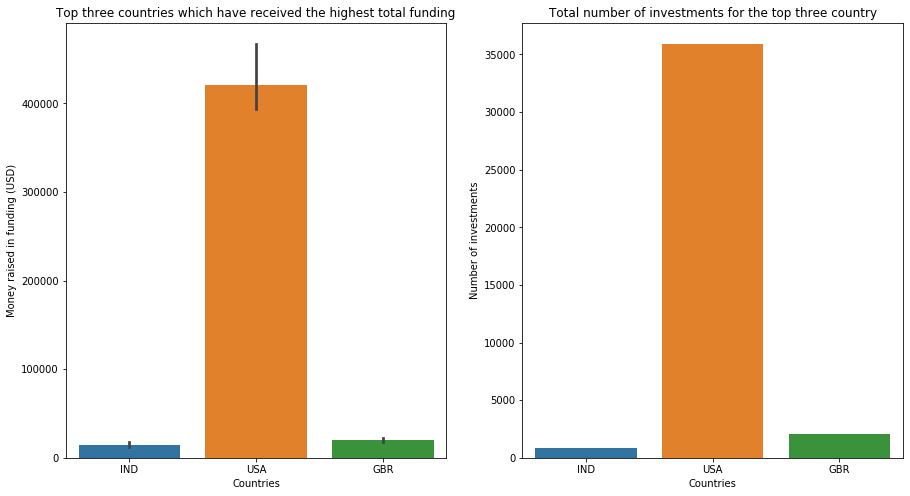

In [33]:
# Plotting the top 3 countries amounts and number of investments

top3 = top9[top9["country_code"].isin(["USA", "GBR", "IND"])]

plt.figure(figsize =( 15,8))
plt.subplot(1, 2, 1)
sns.barplot(top3["country_code"], top3["raised_amount_usd"], estimator = sum)
plt.title("Top three countries which have received the highest total funding")
plt.xlabel("Countries")
plt.ylabel("Money raised in funding (USD)")

plt.subplot(1, 2, 2)
sns.countplot(top3["country_code"])
plt.title("Total number of investments for the top three country")
plt.xlabel("Countries")
plt.ylabel("Number of investments")
plt.show()

In [34]:
# Filtering out the top 3 countries

master_frame = master_frame[master_frame["country_code"].isin(["USA", "GBR", "IND"])]

## Checkpoint 4: Sector Analysis 1

Sector Analysis refers to one of the eight main resources (named main_sector) listed in the mapping file (note that 'Others' is one of the eight main sectors). For example, in the mapping file, category_lists such as '3D', '3D Printing' ,'3D Technology', etc... are mapped to the main sector 'Manufacturing'.


 - Extract the primary sector of each category list from the category_list column
For some companies, the category list is a list of multiple sub-sectors separated by a pipe (vertical bar |). For example, one of the companies’ category_list is Application Platforms|Real Time|Social Network Media.

Business rule is that the first string before the vertical bar will be considered the primary sector. In the example above, ‘Application Platforms’ will be considered the primary sector.

In [35]:
original_master_frame["primary_sector"] = math.nan
original_master_frame["primary_sector"] = original_master_frame["category_list"].str.split("|", expand = True)
original_master_frame["primary_sector"] = original_master_frame["primary_sector"].str.lower()

 - Use the mapping file 'mapping.csv' to map each primary sector to one of the eight main sectors (Note that ‘Others’ is also considered one of the main sectors)

In [36]:
# Loading mappings

mapping = pd.read_csv(path_var + "mapping.csv", encoding = "ISO-8859-1")
mapping.head(5)

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1


In [37]:
round(100 * (mapping.isnull().sum() / len(mapping)), 2)

category_list                              0.15
Automotive & Sports                        0.00
Blanks                                     0.00
Cleantech / Semiconductors                 0.00
Entertainment                              0.00
Health                                     0.00
Manufacturing                              0.00
News, Search and Messaging                 0.00
Others                                     0.00
Social, Finance, Analytics, Advertising    0.00
dtype: float64

In [38]:
# Removing NaN values from category_list column

mapping = mapping[ ~ mapping["category_list"].isnull()]

In [39]:
# Few of the entries have "0" instead of "na", so replacing them with "na"

mapping["category_list"] = mapping["category_list"].replace({"0" : "na"}, regex = True)

In [40]:
# Mapping the "primary_sector" with "main_sector"

mapping = pd.melt(mapping, id_vars = ["category_list"])
mapping = mapping[mapping["value"] == 1]
mapping = mapping.drop('value', axis = 1)
mapping = mapping.rename(columns = {"category_list" : "primary_sector", "variable" : "main_sector"})
mapping["primary_sector"] = mapping["primary_sector"].str.lower()
mapping["main_sector"] = mapping["main_sector"].str.lower()
mapping.head(10)

,primary_sector,main_sector
7,adventure travel,automotive & sports
13,aerospace,automotive & sports
44,auto,automotive & sports
45,automated kiosk,automotive & sports
46,automotive,automotive & sports
56,bicycles,automotive & sports
68,boating industry,automotive & sports
86,cad,automotive & sports
92,cars,automotive & sports
187,design,automotive & sports


 - Merged data frame with each primary sector mapped to its main sector (the primary sector should be present in a separate column).

In [41]:
original_master_frame = original_master_frame.merge(mapping, on = "primary_sector", how = "left")
original_master_frame = original_master_frame[ ~ (original_master_frame["main_sector"].isnull())]
original_master_frame.head(1)

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,primary_sector,main_sector
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10.0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,media,entertainment


## Checkpoint 5: Sector Analysis 2

Now, the aim is to find out the most heavily invested main sectors in each of the three countries (for funding type FT and investments range of 5-15 M USD).

 - Create three separate data frames D1, D2 and D3 for each of the three countries containing the observations of funding type FT falling within the 5-15 million USD range.

In [42]:
# D1, D2, D3 for top three countries Country1, Country2, Country3

D1 = original_master_frame[original_master_frame["country_code"] == "USA"]
D2 = original_master_frame[original_master_frame["country_code"] == "GBR"]
D3 = original_master_frame[original_master_frame["country_code"] == "IND"]

In [43]:
# D1, D2, D3 for funding type venture

D1 = D1[D1['funding_round_type'] == "venture"]
D2 = D2[D2['funding_round_type'] == "venture"]
D3 = D3[D3['funding_round_type'] == "venture"]

In [44]:
# D1, D2, D3 for investment amount within the range of 5 to 15 million USD

D1 = D1[(D1['raised_amount_usd'] >= 5) & (D1['raised_amount_usd'] <= 15)]
D2 = D2[(D2['raised_amount_usd'] >= 5) & (D2['raised_amount_usd'] <= 15)]
D3 = D3[(D3['raised_amount_usd'] >= 5) & (D3['raised_amount_usd'] <= 15)]

Adding the total number (or count) of investments for each main sector in a separate column

Adding the total amount invested in each main sector in a separate column

In [45]:
# Calculating amount and count per sector for D1

D1_sector_frame = D1.groupby("main_sector")
D1_pivot_frame = pd.DataFrame(columns = ["total_amount", "total_count"])
D1_pivot_frame["total_amount"] = D1_sector_frame["raised_amount_usd"].sum()
D1_pivot_frame["total_count"] = D1_sector_frame["main_sector"].count()
D1_pivot_frame.sort_values(by = "total_count", ascending = False)

,total_amount,total_count
main_sector,,
others,26321.007002,2950
"social, finance, analytics, advertising",23807.376964,2714
cleantech / semiconductors,21633.430822,2350
"news, search and messaging",13971.567428,1583
health,8211.859357,909
manufacturing,7258.553378,799
entertainment,5099.197982,591
automotive & sports,1454.104361,167


In [46]:
# Adding the total number (or count) of investments for each main sector in a separate column
# Calculating amount and count per sector for D2

D2_sector_frame = D2.groupby("main_sector")
D2_pivot_frame = pd.DataFrame(columns = ["total_amount", "total_count"])
D2_pivot_frame["total_amount"] = D2_sector_frame["raised_amount_usd"].sum()
D2_pivot_frame["total_count"] = D2_sector_frame["main_sector"].count()
D2_pivot_frame.sort_values(by = "total_count", ascending = False)

,total_amount,total_count
main_sector,,
others,1283.624289,147
"social, finance, analytics, advertising",1089.404014,133
cleantech / semiconductors,1163.990056,130
"news, search and messaging",615.746235,73
entertainment,482.784687,56
manufacturing,361.940335,42
health,214.537510,24
automotive & sports,167.051565,16


In [47]:
# Calculating amount and count per sector for D3

D3_sector_frame = D3.groupby("main_sector")
D3_pivot_frame = pd.DataFrame(columns = ["total_amount", "total_count"])
D3_pivot_frame["total_amount"] = D3_sector_frame["raised_amount_usd"].sum()
D3_pivot_frame["total_count"] = D3_sector_frame["main_sector"].count()
D3_pivot_frame.sort_values(by = "total_count", ascending = False)

,total_amount,total_count
main_sector,,
others,1013.409507,110
"social, finance, analytics, advertising",550.549550,60
"news, search and messaging",433.834545,52
entertainment,280.830000,33
manufacturing,200.900000,21
cleantech / semiconductors,165.380000,20
health,167.740000,19
automotive & sports,136.900000,13


In [48]:
# Merging count and sum of amounts to the main frames

D1 = pd.merge(D1, D1_pivot_frame, on = "main_sector", how = "left")
D2 = pd.merge(D2, D2_pivot_frame, on = "main_sector", how = "left")
D3 = pd.merge(D3, D3_pivot_frame, on = "main_sector", how = "left")

In [49]:
D1.describe()

,raised_amount_usd,total_amount,total_count
count,12063.000000,12063.000000,12063.000000
mean,8.932861,19210.509089,2150.255906
std,3.075861,7386.910723,829.804841
min,5.000000,1454.104361,167.000000
25%,6.000971,13971.567428,1583.000000
50%,8.300000,21633.430822,2350.000000
75%,11.000000,23807.376964,2714.000000
max,15.000000,26321.007002,2950.000000


In [50]:
D2.describe()

,raised_amount_usd,total_amount,total_count
count,621.000000,621.000000,621.000000
mean,8.661962,933.833895,108.307568
std,2.867167,364.628422,42.085594
min,5.000000,167.051565,16.000000
25%,6.084330,615.746235,73.000000
50%,8.000000,1089.404014,130.000000
75%,10.606760,1163.990056,133.000000
max,15.000000,1283.624289,147.000000


In [51]:
D3.describe()

,raised_amount_usd,total_amount,total_count
count,328.000000,328.000000,328.000000
mean,8.992511,575.695320,63.609756
std,3.219811,336.428258,35.953931
min,5.000000,136.900000,13.000000
25%,6.000000,280.830000,33.000000
50%,8.700000,550.549550,60.000000
75%,10.555000,1013.409507,110.000000
max,15.000000,1013.409507,110.000000


## Sector-wise Investment Analysis

### - Total number of investments (count)

Country1 (United States (USA)) - 12063

In [52]:
D1["raised_amount_usd"].count()

12063

Country2 (United Kingdom (GBR)) - 621

In [53]:
D2["raised_amount_usd"].count()

621

Country3 (India (IND)) - 328

In [54]:
D3["raised_amount_usd"].count()

328

### - Total amount of investment (USD)

Country1 (United States (USA)) - 107757.1 million USD

In [55]:
round(D1["raised_amount_usd"].sum(), 2)

107757.1

Country2 (United Kingdom (GBR)) - 5379.08 million USD

In [56]:
round(D2["raised_amount_usd"].sum(), 2)

5379.08

Country3 (India (IND)) - 2949 .54 million USD

In [57]:
round(D3["raised_amount_usd"].sum(), 2)

2949.54

Investments based on count for all the three countries

Country1 (United States (USA)):

In [58]:
D1.groupby("main_sector")["raised_amount_usd"].count().sort_values(ascending = False).head(3)

main_sector
others                                     2950
social, finance, analytics, advertising    2714
cleantech / semiconductors                 2350
Name: raised_amount_usd, dtype: int64

Country2 (United Kingdom (GBR)):

In [59]:
D2.groupby("main_sector")["raised_amount_usd"].count().sort_values(ascending = False).head(3)

main_sector
others                                     147
social, finance, analytics, advertising    133
cleantech / semiconductors                 130
Name: raised_amount_usd, dtype: int64

Country3 (India (IND)):

In [60]:
D3.groupby("main_sector")["raised_amount_usd"].count().sort_values(ascending = False).head(3)

main_sector
others                                     110
social, finance, analytics, advertising     60
news, search and messaging                  52
Name: raised_amount_usd, dtype: int64

### - Top sector (based on count of investments)
 - Country1 (United States (USA)) - Others
 - Country2 (United Kingdom (GBR)) - Others
 - Country3 (India (IND)) - Others

### - Second Sector name (no. of investment-wise)
 - Country1 (United States (USA)) - Social, Finance, Analytics, Advertising
 - Country2 (United Kingdom (GBR)) - Social, Finance, Analytics, Advertising
 - Country3 (India (IND)) - Social, Finance, Analytics, Advertising

### - Third Sector name (no. of investment-wise)
 - Country1 (United States (USA)) - Cleantech / Semiconductors 
 - Country2 (United Kingdom (GBR)) - Cleantech / Semiconductors 
 - Country3 (India (IND)) - News, Search and Messaging 

### - Number of investments in top sector (3)
 - Country1 (United States (USA)) - 2950
 - Country2 (United Kingdom (GBR)) - 147
 - Country3 (India (IND)) - 110

### - Number of investments in second sector (4)
 - Country1 (United States (USA)) - 2714
 - Country2 (United Kingdom (GBR)) - 133
 - Country3 (India (IND)) - 60

### - Number of investments in third sector (5)
 - Country1 (United States (USA)) - 2350
 - Country2 (United Kingdom (GBR)) - 130
 - Country3 (India (IND)) - 52

### - For point 3 (top sector count-wise), which company received the highest investment?

Country1 (United States (USA)): Virtustream

In [61]:
D1[D1["main_sector"] == "others" ].groupby("name")["raised_amount_usd"].sum().sort_values(ascending = False).head(1)

name
Virtustream    64.3
Name: raised_amount_usd, dtype: float64

Country2 (United Kingdom (GBR)) - Electric Cloud 

In [62]:
D2[D2["main_sector"] == "others" ].groupby("name")["raised_amount_usd"].sum().sort_values(ascending = False).head(1)

name
Electric Cloud    37.0
Name: raised_amount_usd, dtype: float64

Country3 (India (IND)) - FirstCry.com

In [63]:
D3[D3["main_sector"] == "others" ].groupby("name")["raised_amount_usd"].sum().sort_values(ascending = False).head(1)

name
FirstCry.com    39.0
Name: raised_amount_usd, dtype: float64

### - For point 4 (second best sector count-wise), which company received the highest investment?

Country1 (United States (USA)): SST Inc. (Formerly ShotSpotter)

In [64]:
D1[D1["main_sector"] == "social, finance, analytics, advertising" ].groupby("name")["raised_amount_usd"].sum().sort_values(ascending = False).head(1)

name
SST Inc. (Formerly ShotSpotter)    67.933006
Name: raised_amount_usd, dtype: float64

Country2 (United Kingdom (GBR)) - Celltick Technologies

In [65]:
D2[D2["main_sector"] == "social, finance, analytics, advertising" ].groupby("name")["raised_amount_usd"].sum().sort_values(ascending = False).head(1)

name
Celltick Technologies    37.5
Name: raised_amount_usd, dtype: float64

Country3 (India (IND)) - Manthan Systems

In [66]:
D3[D3["main_sector"] == "social, finance, analytics, advertising" ].groupby("name")["raised_amount_usd"].sum().sort_values(ascending = False).head(1)

name
Manthan Systems    50.7
Name: raised_amount_usd, dtype: float64

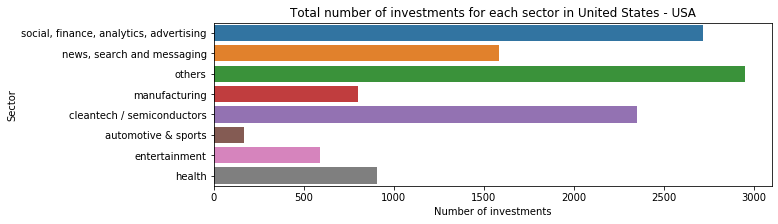

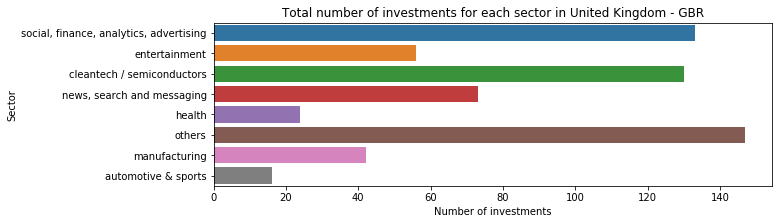

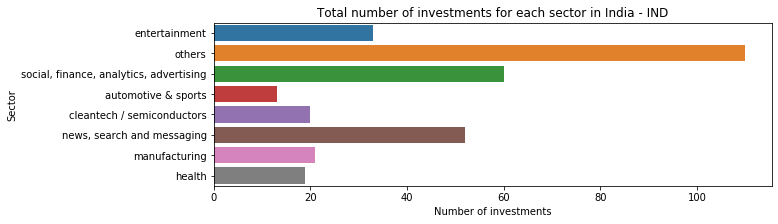

In [67]:
# Plotting sector analysis for top 3 countries

plt.figure(figsize = (10,3))
sns.countplot(y = "main_sector", data = D1)
plt.title("Total number of investments for each sector in United States - USA")
plt.xlabel("Number of investments")
plt.ylabel("Sector")
plt.show()

plt.figure(figsize = (10,3))
sns.countplot(y = "main_sector", data = D2)
plt.title("Total number of investments for each sector in United Kingdom - GBR")
plt.xlabel("Number of investments")
plt.ylabel("Sector")
plt.show()

plt.figure(figsize = (10,3))
sns.countplot(y = "main_sector", data = D3)
plt.title("Total number of investments for each sector in India - IND")
plt.xlabel("Number of investments")
plt.ylabel("Sector")
plt.show()

### "Others" is the sector which is most widely invested in among the three top countries, followed by "Social, Finance, Analytics, Advertising" sector.

## Checkpoint 6: Plots

### - A plot showing the fraction of total investments (globally) in angel, venture, seed, and private equity, and the average amount of investment in each funding type. This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds.

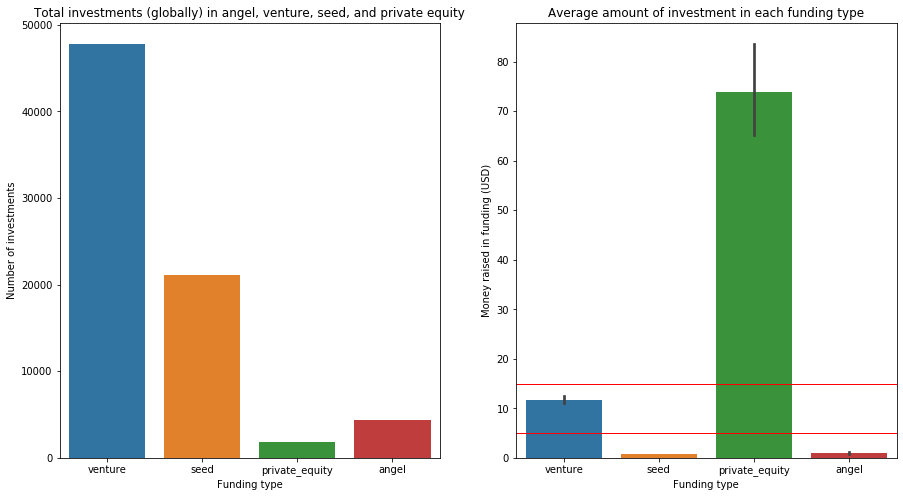

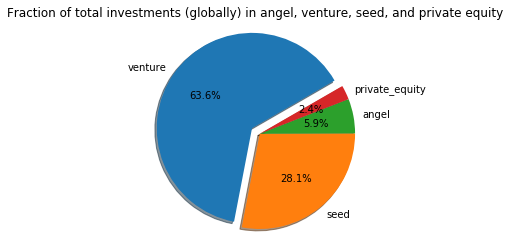

In [68]:
plt.figure(figsize = (15, 8))

plt.subplot(1, 2, 1)
sns.countplot(plots_frame["funding_round_type"])
plt.title("Total investments (globally) in angel, venture, seed, and private equity")
plt.xlabel("Funding type")
plt.ylabel("Number of investments")

plt.subplot(1, 2, 2)
sns.barplot(plots_frame["funding_round_type"], plots_frame["raised_amount_usd"], estimator = np.mean)
plt.title("Average amount of investment in each funding type")
plt.xlabel("Funding type")
plt.ylabel("Money raised in funding (USD)")
plt.axhline(y = 5, linewidth = 1, color = "red")
plt.axhline(y = 15, linewidth = 1, color = "red")
plt.show()

investment_types_count = plots_frame["funding_round_type"].value_counts()
venture_counts = investment_types_count.values
ventures = investment_types_count.index.tolist()
total_investments = len(plots_frame["funding_round_type"])
percentages_FT = list(map(lambda x : round((x / total_investments) * 100, 2), venture_counts))

explode = (0.1, 0, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(percentages_FT, explode = explode, labels = ventures, autopct = "%1.1f%%", shadow = True, startangle = 30)
ax1.axis("equal")
plt.title("Fraction of total investments (globally) in angel, venture, seed, and private equity")
plt.show()

### - A plot showing the top 9 countries against the total amount of investments of funding type FT. This should make the top 3 countries (Country 1, Country 2, and Country 3) very clear.

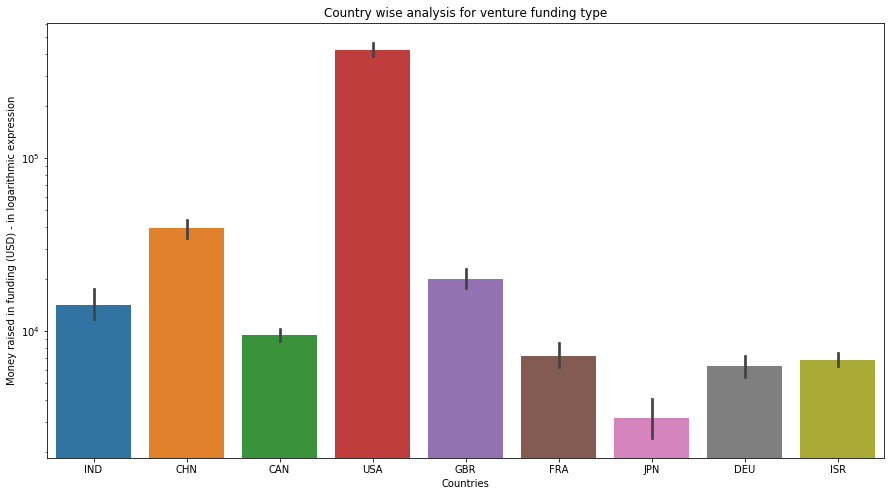

In [69]:
plt.figure(figsize = (15,8))

top9["raised_amount_usd"] = top9["raised_amount_usd"]
sns.barplot(top9["country_code"], top9["raised_amount_usd"], estimator = np.sum)
plt.yscale("log")
plt.ylabel("Money raised in funding (USD) - in logarithmic expression")
plt.xlabel("Countries")
plt.title("Country wise analysis for venture funding type")
plt.show()

### - A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart (for the chosen investment type FT). 

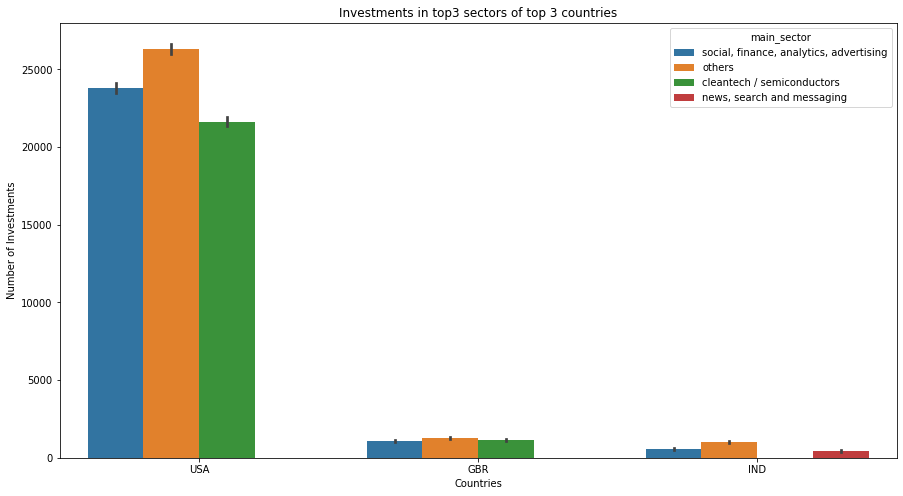

In [70]:
plt.figure(figsize = (15,8))

D1 = D1[D1["main_sector"].isin(["others","social, finance, analytics, advertising", "cleantech / semiconductors"])]
D2 = D2[D2["main_sector"].isin(["others","social, finance, analytics, advertising", "cleantech / semiconductors"])]
D3 = D3[D3["main_sector"].isin(["others","social, finance, analytics, advertising","news, search and messaging"])]

overall_frames = pd.concat([D1, D2, D3])
sns.barplot(overall_frames["country_code"], overall_frames["raised_amount_usd"], estimator = np.sum, hue = "main_sector", data = overall_frames)
plt.xlabel("Countries")
plt.ylabel("Number of Investments")
plt.title("Investments in top3 sectors of top 3 countries")
plt.show()

## Conclusion
### Spark Funds must invest in a company in United States of America (USA) in the Social, Finance, Analytics, Advertising sector with Venture as the funding type.

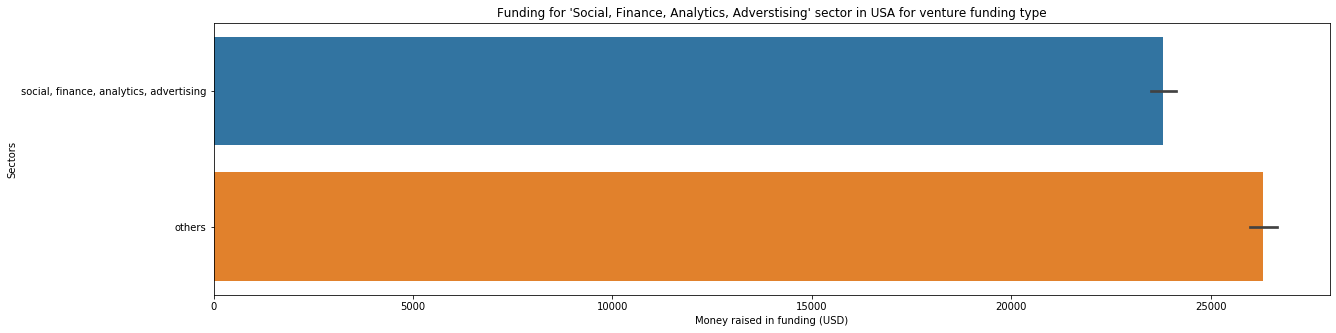

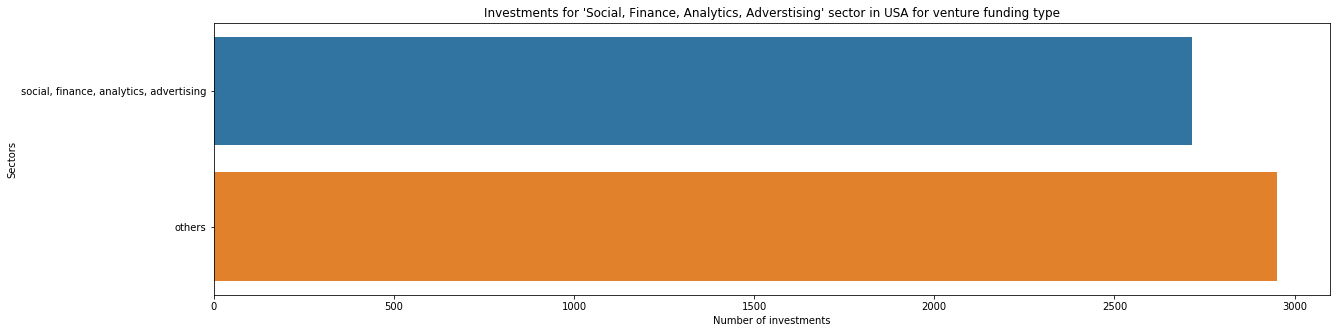

In [71]:
# Plotting the total funding and investments for "Social, Finance, Analytics, Adverstising" in USA with venture funding type

D1 = D1[D1["main_sector"].isin(["others","social, finance, analytics, advertising"])]

plt.figure(figsize = (20,5))
sns.barplot(y = "main_sector", x = "raised_amount_usd", data = D1, estimator = sum)
plt.title("Funding for 'Social, Finance, Analytics, Adverstising' sector in USA for venture funding type")
plt.xlabel("Money raised in funding (USD)")
plt.ylabel("Sectors")
plt.show()

plt.figure(figsize = (20,5))
sns.countplot(y = "main_sector", data = D1)
plt.title("Investments for 'Social, Finance, Analytics, Adverstising' sector in USA for venture funding type")
plt.xlabel("Number of investments")
plt.ylabel("Sectors")
plt.show()